# **Using Isolation Trees to Identify Anomalies in HR Data**
Adam McKinnon and I decided to explore the use of isolation trees to identify anomalies in HR data. We used the IBM Attrition dataset available on the Kaggle website to demonstrate how this work can be done. 

This project is done all in Python, using the [H2O library](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/if.html#). 

## **Table of Contents**

* [Introduction & Business Problem](#introduction)
* [Data & Libraries](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Conclusion](#conclusion)

(This project was a collaboration between myself and Adam McKinnon.)

### **Introduction & Business Problem** <a name="introduction"></a>

**Business Problem**

The topic of data quality is like that of I.T. services generally… you only ever hear about it when there’s a problem! There appears a universal and implicit assumption among stakeholders receiving the findings of people analytics initiatives that your data is “good”. Failure to observe this assumption of high-quality data can significantly (and rapidly) undermine the credibility of findings, irrespective of how small the data quality deviation! 

From an analytical perspective, the quality of your insights can be potentially limited by flawed data. As the saying goes “garbage in, garbage out”. Coupled with stakeholder expectations, it becomes increasingly important that analytics practitioners invest time and energy in the assessment and curation of high-quality data to maximise the influence of analytics on decision making in their organisations. 

At the same time, monitoring data quality can be immensely time consuming, simplistic in execution (i.e., simple evaluation criteria such as age ranges), highly repetitive, and utterly devoid of ANY professional enjoyment! To overcome these shortcomings, we have developed an automated, sophisticated, multi-dimensional and scalable approach to data quality evaluation using unsupervised machine learning—Isolation Forests. 

**The Process**

We will use Isolation Forests, an unsupervised machine learning approach, to scan employee data for potentially anomalous records.  


### **Data & Libraries** <a name="data"></a>

For this project, we used the IBM HR Attrition dataset ([available on the Kaggle website](https:/https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset)). This particular set of data has 35 variables, including a mixture of quantitative and qualitative. 

There are a few options when it comes to packages that support use of the isolation forrest algorithm (our model of choice for this project - more on that later). We decided to use the H2O package because it limits the amount of data transformation that needs to be done. Alternative packages require you to one-hot-encode the data, whereas the H2O package works with a mixture of quantiative and qualitative data. 

After installing the H2O and Pandas libraries, we ingested the HR data and did some minor cleanup of column names. 



####Install h20 and import libraries

In [1]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

^C


In [1]:
import pandas as pd
import h2o
h2o.init()

from h2o.estimators import H2OIsolationForestEstimator
from h2o.estimators import H2ORandomForestEstimator

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.341-b10, mixed mode)
  Starting server from C:\Python310\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\asus\AppData\Local\Temp\tmp44lxg7s1
  JVM stdout: C:\Users\asus\AppData\Local\Temp\tmp44lxg7s1\h2o_asus_started_from_python.out
  JVM stderr: C:\Users\asus\AppData\Local\Temp\tmp44lxg7s1\h2o_asus_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Asia/Tehran
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_asus_7zzfnn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.490 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


####Download data

In [2]:
#load IBM attrition data using h20
employee_data = h2o.import_file('train.csv')

#preview the column names to select those to be included in the analysis
employee_data.columns

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [3]:
#rename the first column since it imported with extra characters
# employee_data = employee_data.rename({'ÃƒÆ’Ã†â€™Ãƒâ€šÃ‚Â¯ÃƒÆ’Ã¢â‚¬Å¡Ãƒâ€šÃ‚Â»ÃƒÆ’Ã¢â‚¬Å¡Ãƒâ€šÃ‚Â¿Age': 'Age'})

#print the dataframe shape and preview the table
print(employee_data.shape)
employee_data.head()

(891, 12)


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,nan,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,nan,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,nan,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S
6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C


In [121]:
# employee_data=employee_data.drop([0],axis=0)

### **Methodology** <a name="methodology"></a>

The Isolation Forest algorithm partitions data through a forest of decision trees. Each split of the data is made randomly and the number of splits it takes to isolate a record indicates whether the record is an anomaly. When a forest of random trees collectively produces shorter path lengths for particular samples, they are highly likely to be anomalies [(see their site for a more detailed explanation)](https://github.com/h2oai/h2o-tutorials/blob/master/tutorials/isolation-forest/interpreting_isolation-forest.ipynb). 

In the end, the Isolation Forest algorithm allows us to separate potentially anomalous data points from the rest. 


### **Analysis** <a name="analysis"></a>

####Run Isolation Trees algorithm on the data

Before running the algorithm, we will select the dataset columns we want to include in the data quality assessment. Then, we will train the isolation tree algorithm on the selected data. 

In [4]:
#define the columns of data we will use in our analysis
# x_var = ['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 
#          'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate',
#          'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'StandardHours', 
#          'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
#          'YearsSinceLastPromotion', 'YearsWithCurrManager']
x_var=employee_data.columns[1:]
#train the isolation trees model
isolation_model = H2OIsolationForestEstimator(model_id = 'isolation_forest.hex', seed = 1234)
training = isolation_model.train(training_frame = employee_data, x = x_var)
training

isolationforest Model Build progress: |

c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [Name]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████| (done) 100%


Model Details
=============
H2OIsolationForestEstimator : Isolation Forest
Model Key: isolation_forest.hex


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          34757                  8            8            8             15            94            51.42

ModelMetricsAnomaly: isolationforest
** Reported on train data. **

Anomaly Score: 5.715754864781612
Normalized Anomaly Score: 0.3819194773629686

Scoring History: 
     timestamp            duration    number_of_trees    mean_tree_path_length    mean_anomaly_score
---  -------------------  ----------  -----------------  -----------------------  --------------------
     2022-10-12 12:53:20  0.046 sec   0.0                nan                      nan
     2022-10-12 12:53:20  0.204 sec   1.0                5.658385093167702        0.26832298136646
     2022-10-12 12:53:20  0.247 sec   2.0                5.846060606060606        0.23078787878787901
     2022-10-12 12:53:20  0.270 sec   3.0                6.088451139436075        0.1953318986922694
     2022-10-12 12:53:20  0.294 sec   4.0                6.088612368024137        0.2430367018602321
     2022-10-12 12:53:20  0.326 sec   5.0                6.140757405324337        0.2685133108361454
     2022-10-12 12:53:20  0.338 sec   6.0                6.203348297792746        0.23899551066217783
     2022-10-12 12:53:20  0.350 sec   7.0                6.271059804393131        0.25512906846240135
     2022-10-12 12:53:20  0.358 sec   8.0                6.183894500561166        0.29676563615957646
     2022-10-12 12:53:20  0.367 sec   9.0                6.220927529260871        0.29215217652717634
---  ---                  ---         ---                ---                      ---
     2022-10-12 12:53:21  0.714 sec   41.0               5.714192652908785        0.37344654683901013
     2022-10-12 12:53:21  0.726 sec   42.0               5.736335732956997        0.37696929916639643
     2022-10-12 12:53:21  0.740 sec   43.0               5.7517684419933195       0.35879959042178255
     2022-10-12 12:53:21  0.760 sec   44.0               5.763441009775677        0.3523724364208278
     2022-10-12 12:53:21  0.780 sec   45.0               5.78633982663668         0.3542633743243097
     2022-10-12 12:53:21  0.797 sec   46.0               5.792861384397748        0.36264565429085993
     2022-10-12 12:53:21  0.807 sec   47.0               5.80956689182062         0.36065144522621456
     2022-10-12 12:53:21  0.819 sec   48.0               5.719840494795796        0.38650135869392993
     2022-10-12 12:53:21  0.827 sec   49.0               5.704077194859069        0.4043497169730921
     2022-10-12 12:53:21  0.836 sec   50.0               5.715754864781612        0.3819194773629686
[51 rows x 6 columns]


[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

Using the trained Isolation Forest model (above), we see an anamoly score of 6.69140874713062. We will use this value as the cutoff when labeling records that are likely anomalies. 

First, let's visualize the predictions using a histogram. 

In [123]:
x_var

['Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%


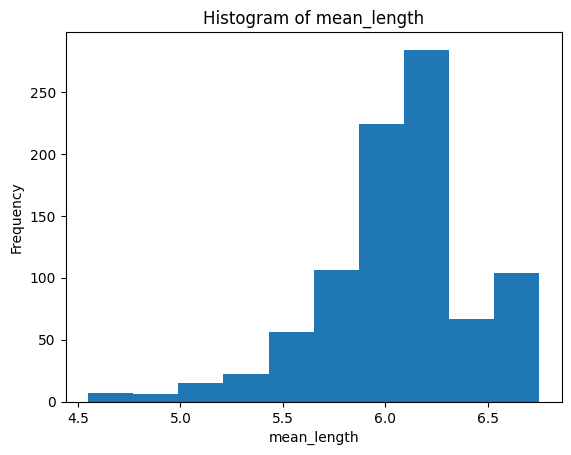

breaks,counts,mids_true,mids,widths
4.44,nan,nan,nan,nan
4.66,7,2.11,4.55,0.22
4.88,6,2.29,4.77,0.22
5.1,15,2.33,4.99,0.22
5.32,22,2.44,5.21,0.22
5.54,56,2.56,5.43,0.22
5.76,106,2.66,5.65,0.22
5.98,224,2.77,5.87,0.22
6.2,284,2.88,6.09,0.22
6.42,67,2.99,6.31,0.22


In [5]:
#define the preductions
predictions = isolation_model.predict(employee_data)

#plot a histogram of the mean_length scores to identify the cutoff for anomalies
predictions['mean_length'].hist()

####Define the anomalies

Let's now see how many records have been identified as an anomaly using the anomaly score from the model above.

In [6]:
employee_data.shape

(891, 12)

In [7]:
#print the number of anomalies identified by the model
anomalies = employee_data[predictions['mean_length'] < 5.54]
print('Number of Anomalies: ' + str(anomalies.nrow))
print('Number of Anomalies as Percent of Total: ', str(anomalies.nrow/891))
anomalies

Number of Anomalies: 212
Number of Anomalies as Percent of Total:  0.23793490460157127


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.4583,,Q
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4,1,1,nan,16.7,G6,S
14,0,3,"Andersson, Mr. Anders Johan",male,39,1,5,347082,31.275,,S
16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55,0,0,248706,16,,S
17,0,3,"Rice, Master. Eugene",male,2,4,1,382652,29.125,,Q
26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)",female,38,1,5,347077,31.3875,,S
28,0,1,"Fortune, Mr. Charles Alexander",male,19,3,2,19950,263,C23 C25 C27,S
31,0,1,"Uruchurtu, Don. Manuel E",male,40,0,0,nan,27.7208,,C


two time get prediction from model:

In [8]:
isolation_model.predict(employee_data[isolation_model.predict(employee_data)['mean_length'] < 5.54])

isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%
isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%


predict,mean_length
0.479339,5.48
0.520661,5.38
0.487603,5.46
0.528926,5.36
0.710744,4.92
0.528926,5.36
0.785124,4.74
0.61157,5.16
0.545455,5.32
0.570248,5.26


In [9]:
#create a dataframe of the records identified as an anomaly from the model
anomaly_records = isolation_model.predict(anomalies)['mean_length'].cbind(anomalies[x_var])
print(anomaly_records.shape)
anomaly_records.head()

isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%
(212, 12)


mean_length,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5.48,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.4583,,Q
5.38,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S
5.46,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C
5.36,1,3,"Sandstrom, Miss. Marguerite Rut",female,4,1,1,nan,16.7,G6,S
4.92,0,3,"Andersson, Mr. Anders Johan",male,39,1,5,347082,31.275,,S
5.36,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55,0,0,248706,16,,S
4.74,0,3,"Rice, Master. Eugene",male,2,4,1,382652,29.125,,Q
5.16,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)",female,38,1,5,347077,31.3875,,S
5.32,0,1,"Fortune, Mr. Charles Alexander",male,19,3,2,19950,263,C23 C25 C27,S
5.26,0,1,"Uruchurtu, Don. Manuel E",male,40,0,0,nan,27.7208,,C


Next, we divide the anomalies into quartiles, allowing us to prioritize those that are most likely an anomaly over others that may be. This step is of course optional, depending on the number of anomalies identified, the standard of data quality that's needed, and the resources available to check the anomalies. 

In [10]:
#convert anomaly_records to Pandas dataframe to manipulate and calculate quartiles
anomalies_df = h2o.as_list(anomaly_records)
anomalies_df.head()

#create a column for quartiles
anomalies_df.insert(1, 'Quartile', '')

#calculate the quartile of each mean_length
anomalies_df['Quartile'] = pd.qcut(anomalies_df['mean_length'], q=4)

print("Quartile Values: ", anomalies_df['Quartile'].unique())
anomalies_df.shape

Quartile Values:  [(5.44, 5.52], (5.31, 5.44], (4.218999999999999, 5.135], (5.135, 5.31]]
Categories (4, interval[float64, right]): [(4.218999999999999, 5.135] < (5.135, 5.31] < (5.31, 5.44] < (5.44, 5.52]]


(212, 13)

In [12]:
#create a df of each quartile and print the shape of each
first = anomalies_df.loc[anomalies_df['mean_length'] <5.135]
second = anomalies_df.loc[(anomalies_df['mean_length'] > 5.135) & (anomalies_df['mean_length'] < 5.31)]
third = anomalies_df.loc[(anomalies_df['mean_length'] > 5.31) & (anomalies_df['mean_length'] <5.44)]
fourth = anomalies_df.loc[anomalies_df['mean_length'] > 5.44]

print('# of 1st quartile: ', first.shape)
print('# of 2nd quartile: ', second.shape)
print('# of 3rd quartile: ', third.shape)
print('# of 4th quartile: ', fourth.shape)

# of 1st quartile:  (53, 13)
# of 2nd quartile:  (53, 13)
# of 3rd quartile:  (45, 13)
# of 4th quartile:  (51, 13)


In [13]:
#redefine the anomalies df using the first quartile cutoff
anomalies_first = employee_data[(predictions['mean_length'] > 4.96) & (predictions['mean_length'] < 5.14)]

#copy employee data dataframe to analyize a single record previously identified as an anomaly
local_surrogate_data = employee_data[:, :]

In [19]:
#create Pandas df of anomalies table
anomalies_df = anomalies_first.as_data_frame()

#create a small test df - remove this code to run the model on the full df
anomalies_df = anomalies_df.head(20)

#create list of employees
df_id = anomalies_df['PassengerId'].tolist()

#create empty dictionary and df to populate with output from the model
anomalies_dict = {}
df_output = pd.DataFrame()

In [20]:
df_id

[44, 117, 180, 272, 281, 361, 374, 470, 484, 546, 558, 611, 634, 645, 775, 828]

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
#create loop to run model and extract variables with anomalies
anomalies_dict = {}
df_output = pd.DataFrame()
for E in df_id: 
  num = 3
  for x in range(num):
    
    #train model on anomaly record
    local_surrogate_data["anomaly_record"] = (local_surrogate_data["PassengerId"] == E).ifelse("Anomaly", "NotAnomaly")

    local_surrogate_dt = H2ORandomForestEstimator(model_id = "local_level_surrogate_decision_tree.hex", 
                                                ntrees = 1, max_depth = 4,
                                                sample_rate = 1)
    local_surrogate_dt.train(training_frame = local_surrogate_data, x = x_var, y = "anomaly_record")

    #isolate variables with importance and create a frame
    local_table = local_surrogate_dt.varimp()
    frame = h2o.H2OFrame(local_table, header=-1)

    #convert frame to Pandas df to manipulate and populate dictionary
    df = frame.as_data_frame()
    df = df[df.C4 != 0]

    #calculate C4 - C2 to identify variables that need to be checked
    diff = (df['C4'].sum()) - (df['C2'].sum())

    #add values to dictionary and append to df 
    cols = df['C1'].tolist()
    anomalies_dict = {'PassengerId': E, 'Variables': cols, 'Result': diff}
    df_output = df_output.append(anomalies_dict, ignore_index=True)

    print(f'id {E}  completed: ')


df_output = df_output[df_output.Result!=None]

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
id 44  completed: 
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
id 44  completed: 
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
id 44  completed: 
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
id 117  completed: 
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Parse progress: |███████████████████████████████████████████████████

We now have a Pandas df of the employee number and variables that were flagged as anomalous by the model. Let's now group the variables by employee number and only keep those that came up more than once. 

In [22]:
df_output

,PassengerId,Variables,Result
0,44,"[Ticket, Parch]",0.972551
1,44,"[Fare, Sex]",0.501122
2,44,"[SibSp, Age, Sex]",0.001122
3,117,"[Fare, Survived, Sex]",0.990484
4,117,"[Age, Ticket]",0.001122
5,117,"[Age, Ticket]",0.001122
6,180,"[Age, Fare]",0.001122
7,180,"[Ticket, Age, Survived, Fare]",0.501122
8,180,"[Age, Ticket, Fare]",0.001122
9,272,"[Ticket, Pclass]",0.991948


In [23]:
#explode lists into rows for each row
df_final = df_output.explode('Variables')

#group the df by employee number and count the number of times the variable comes up
df_final = df_final.groupby(['PassengerId', 'Variables']).size().reset_index(name='Count')

#sort by employee number then by count (descending)
df_final = df_final.sort_values(['PassengerId', 'Count'], ascending = [True, False ])

#drop rows where count < 2
df_final = df_final[df_final.Count > 1]

#group by EmployeeNumber and create list of variables, in rank order by highest frequency to lowest
df_final = df_final.groupby('PassengerId')['Variables'].apply(list).reset_index()


df_final

,PassengerId,Variables
0,44,[Sex]
1,117,"[Age, Ticket]"
2,180,"[Age, Fare, Ticket]"
3,272,[Ticket]
4,281,"[Age, Fare]"
5,361,"[Age, Parch, Fare]"
6,374,[Ticket]
7,470,"[Age, SibSp, Ticket]"
8,484,[Age]
9,546,"[Age, Ticket]"
